### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm.auto as tqdm
from tqdm.auto import tqdm

from pii import decomp, utils

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("attrib"),
        utils.get_style("1col"),
    ]
)
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

### Load model

In [3]:
# pick model to run on
# or meta-llama/Llama-2-7b-chat-hf or meta-llama/Llama-2-13b-chat-hf
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"

# pick a dataset to run on
# "counterfact" or "hqfact"
DATASET_NAME = "counterfact"

# You will need to login to huggingface first:
#   huggingface-cli login
if MODEL_NAME == "meta-llama/Llama-2-7b-chat-hf":
    tl_model = utils.get_llama2_7b_chat_tl_model()
    SAVED_NAME = "llama2_7b"
    n_devices = 1 
    batch_size = 5
elif MODEL_NAME == "meta-llama/Llama-2-13b-chat-hf":
    tl_model = utils.get_llama2_13b_chat_tl_model()
    SAVED_NAME = "llama2_13b"
    n_devices = 1
    batch_size = 1
else:
    raise ValueError("Unsupported model")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-2-13b-chat-hf into HookedTransformer


In [4]:
with torch.no_grad():
    print(
        tl_model.generate(
            "The capital of Germany is", max_new_tokens=20, temperature=0
        )
    )

    _, tmp_cache = tl_model.run_with_cache("hi")
    LABELS = np.array(
        decomp.get_all_resid_components(
            tl_model=tl_model, cache=tmp_cache, pos=-1, batch_idx=0
        ).labels
    )
    print(LABELS[:5])

  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin.

The currency of Germany is the Euro.

The official language of Germany is
['EMBED' 'L0H0ATN' 'L0H1ATN' 'L0H2ATN' 'L0H3ATN']


### Load dataset

In [5]:
inference_filename = f"{DATASET_NAME}_inference_{SAVED_NAME}.csv"
df_raw = pd.read_csv(
    utils.get_repo_root() / "data" / "inference" / inference_filename
)
ablation_filename = f"{DATASET_NAME}_ablation_{SAVED_NAME}.pkl"
df = pd.read_pickle(
    utils.get_repo_root() / "data" / "ablation" / ablation_filename
)
df.keys()

Index(['case_id', 'pararel_idx', 'relation_id', 'subject', 'target_new_str',
       'target_true_str', 'fact_prefix', 'irrelevant_word', 'prompt_c',
       'prompt_nc0', 'prompt_nc1', 'p_correct_c', 'p_correct_nc0',
       'p_correct_nc1', 'lo_correct_c', 'lo_correct_nc0', 'lo_correct_nc1',
       'log_bf0', 'log_bf1', 'lo_correct_c_nc0', 'lo_correct_c_nc1',
       'lo_correct_nc0_c', 'lo_correct_nc1_c', 'lo_correct_c_nc0_dcum',
       'lo_correct_c_nc1_dcum', 'lo_correct_nc0_c_dcum',
       'lo_correct_nc1_c_dcum', 'lo_correct_c_nc0_cum', 'lo_correct_c_nc1_cum',
       'lo_correct_nc0_c_cum', 'lo_correct_nc1_c_cum'],
      dtype='object')

In [6]:
log_bf_nc_c = np.concatenate(
    [
        np.stack(df.lo_correct_nc0_c) - df.lo_correct_nc0.to_numpy()[:, None],
        np.stack(df.lo_correct_nc1_c) - df.lo_correct_nc1.to_numpy()[:, None],
    ]
)
log_bf_c_nc = np.concatenate(
    [
        np.stack(df.lo_correct_c_nc0) - df.lo_correct_c.to_numpy()[:, None],
        np.stack(df.lo_correct_c_nc1) - df.lo_correct_c.to_numpy()[:, None],
    ]
)
print(log_bf_c_nc.shape, log_bf_nc_c.shape)

COMPONENT_ORDER = np.argsort(log_bf_nc_c.mean(axis=0))
LABELS_ORDERED = LABELS[COMPONENT_ORDER]
ATN_HEAD_LABEL_MASK = np.array([("ATN" in label) for label in LABELS_ORDERED])
print(LABELS_ORDERED[:10])

ATTN_HEAD_LOCS = [
    (int(label.split("H")[0][1:]), int(label.split("H")[1][:-3]))
    for label in LABELS_ORDERED[ATN_HEAD_LABEL_MASK]
]
print(ATTN_HEAD_LOCS[:5])

(4994, 1641) (4994, 1641)
['L33H11ATN' 'L34H6ATN' 'L39H23ATN' 'L39MLP' 'L32H5ATN' 'L35H10ATN'
 'L35H29ATN' 'L27H15ATN' 'L16H3ATN' 'L29H27ATN']
[(33, 11), (34, 6), (39, 23), (32, 5), (35, 10)]


### Compute attention response

In [7]:
def get_forbidden_token_range(
    prompt: str, forbidden_word: str
) -> tuple[int, int]:
    tokens = tl_model.to_tokens(prompt)[0]
    start = 47
    for end in range(start + 1, len(tokens) + 1):
        if tl_model.to_string(tokens[start:end]) == forbidden_word:
            return (start, end)
    raise ValueError("forbidden word not found")

metrics = []
pbar = tqdm(range(0, len(df), batch_size))
for idx_start in pbar:
    idx_end = min(idx_start + batch_size, len(df))

    prompts: list[str] = []
    forb_words: list[str] = []
    for idx in range(idx_start, idx_end):
        prompts.extend(
            [
                df.prompt_c[idx],
                df.prompt_nc0[idx],
                df.prompt_nc1[idx],
            ]
        )
        forb_words.extend(
            [
                df.target_true_str[idx],
                df.target_new_str[idx],
                df.irrelevant_word[idx],
            ]
        )

    with torch.no_grad():
        _, cache = tl_model.run_with_cache(prompts)

        forb_attns = torch.zeros(
            (len(prompts), tl_model.cfg.n_layers, tl_model.cfg.n_heads)
        )
        for i in range(len(prompts)):
            fstart, fend = get_forbidden_token_range(prompts[i], forb_words[i])
            prompt_len = len(tl_model.to_tokens(prompts[i])[0])
            for layer_num in range(tl_model.cfg.n_layers):
                forb_attns[i, layer_num, :] = cache["pattern", layer_num][
                    i, :, prompt_len - 1, fstart:fend
                ].sum(dim=-1)

    for i in range(idx_end - idx_start):
        metrics.append(
            dict(forb_attn=forb_attns[3 * i : 3 * i + 3].cpu().numpy())
        )

df = df.assign(**pd.DataFrame(metrics))

  0%|          | 0/2497 [00:00<?, ?it/s]

### Compute OV response

In [8]:
fas = np.stack(df.forb_attn)
log10odds_fas = torch.tensor(fas).logit().cpu().numpy()
fas.shape

(2497, 3, 40, 40)

In [7]:
def get_ov_resp_matrix(layer: int, head: int):
    """Returns a matrix in units of log_e-prob."""
    W_O = tl_model.W_O[layer, head]
    W_V = tl_model.W_V[layer, head]

    with torch.no_grad():
        raw_logits = utils.unembed(
            tl_model.blocks[layer].ln1(tl_model.W_E) @ W_V @ W_O,
            tl_model=tl_model,
        ).double()

        logits = utils.logit_softmax(raw_logits)

        return logits


def plot_ov_resp_matrix(
    layer: int,
    head: int,
    top_tokens: int = 3,
    largest: bool = False,
):
    d = tl_model.cfg.d_vocab
    log10_resp_mat = get_ov_resp_matrix(layer=layer, head=head) / np.log(10)
    log10_resp_diag = log10_resp_mat.diag()

    top_tokens = torch.topk(
        log10_resp_diag, top_tokens, largest=largest
    ).indices

    suppression_score = (
        (log10_resp_diag.mean() - log10_resp_mat.mean()).item() * d / (d - 1)
    )
    get_sgn = lambda x: "+" if x > 0 else ""
    get_tok_score = lambda tok: log10_resp_diag[tok.item()]
    plt.text(
        0.5,
        0.9,
        "\n".join(
            [
                "OV Suppression",
                f"Dist., Mean: {get_sgn(suppression_score)}${suppression_score:.1f}$",
            ]
        ),
        horizontalalignment="center",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    plt.text(
        0.5,
        -0.35,
        "\n".join(
            [
                f"{tl_model.to_string(tok.item())}: {get_sgn(get_tok_score(tok))}${get_tok_score(tok):.3f}$"
                for tok in top_tokens
            ]
        ),
        horizontalalignment="center",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    utils.plot_hist_from_tensor(
        xs=(log10_resp_diag - log10_resp_mat).flatten(),
        anti_xs=torch.zeros_like(log10_resp_diag),
        bins=500,
        density=True,
        alpha=0.5,
        label="Off-diagonal",
        color="tab:orange",
    )

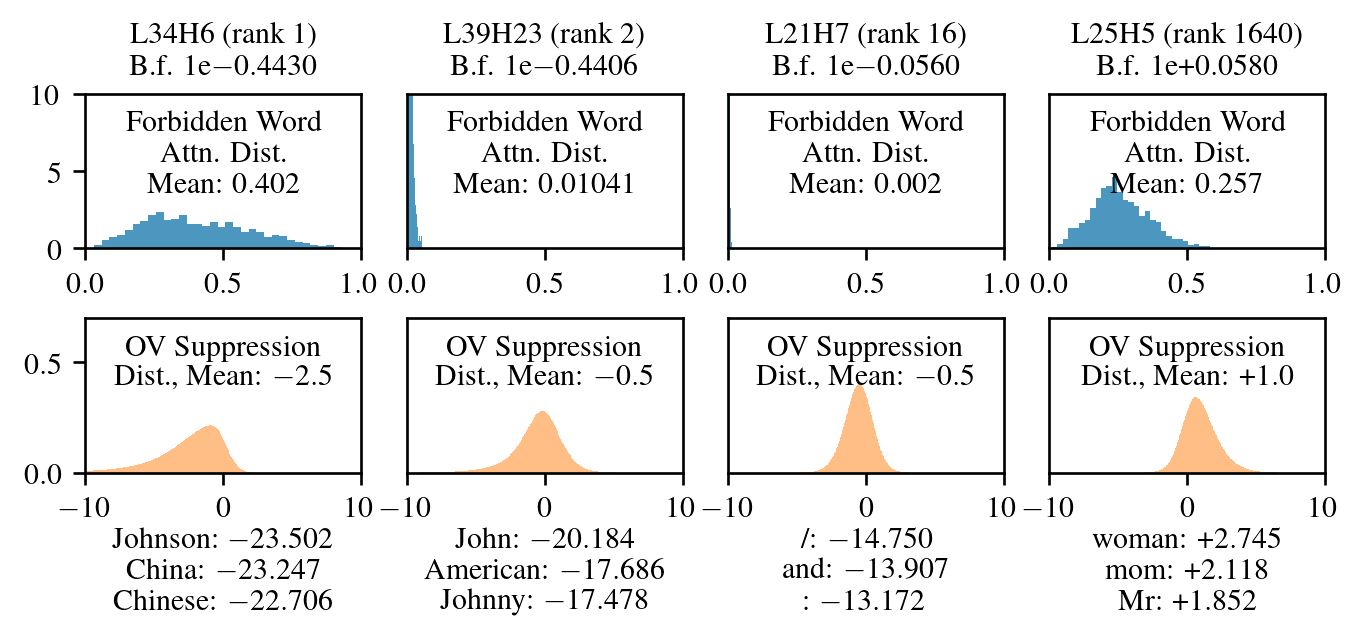

In [32]:
# PLOT_HEADS = [(18, 9, False), (25, 12, False), (28, 7, False), (14, 5, False), (29, 19, True)]
# PLOT_HEADS = [(18, 9, False), (25, 12, False), (28, 7, False), (29, 19, True)]
# PLOT_HEADS = [(18, 9, False), (31, 27, False), (19, 13, False), (29, 19, True)]
PLOT_HEADS = [ATTN_HEAD_LOCS[1] + (False,), ATTN_HEAD_LOCS[2] + (False,), ATTN_HEAD_LOCS[15] + (False,), (25, 5, True)]
fig, _ = plt.subplots(2, 4, height_ratios=[1, 1])
plt.rcParams["ytick.right"] = False

get_sgn = lambda x: "+" if x > 0 else ""
for i, (layer, head, _) in enumerate(PLOT_HEADS):
    plt.subplot(2, 4, i + 1)
    log10_bf = log_bf_nc_c.mean(axis=0)[
        list(LABELS).index(f"L{layer}H{head}ATN")
    ] / np.log(10)
    rank = LABELS_ORDERED.tolist().index(f"L{layer}H{head}ATN")
    plt.title(
        f"L{layer}H{head} (rank {rank})\nB.f. 1e{get_sgn(log10_bf)}${{{log10_bf:.4f}}}$",
        fontsize=9,
    )

    plt.hist(
        # log10odds_fas[:, 0, layer, head],
        fas[:, 0, layer, head],
        density=True,
        bins=32,
        alpha=0.7,
    )
    plt.xlim(0, 1)
    plt.ylim(0, 10)

    plt.text(
        0.5,
        0.9,
        "\n".join(
            [
                "Forbidden Word",
                "Attn. Dist.",
                f"Mean: ${fas[:, 0, layer, head].mean():.3f}$"
                if i != 1
                else f"Mean: ${fas[:, 0, layer, head].mean():.5f}$",
            ]
        ),
        horizontalalignment="center",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    plt.gca().yaxis.set_ticks_position("left")
    if i > 0:
        # Turn off y-axis labels
        plt.yticks([])


for i, (layer, head, largest) in enumerate(PLOT_HEADS):
    plt.subplot(2, 4, 4 + i + 1)
    plot_ov_resp_matrix(
        layer=layer,
        head=head,
        top_tokens=3,
        largest=largest,
    )
    plt.gca().yaxis.set_ticks_position("left")
    if i > 0:
        # Turn off y-axis labels
        plt.yticks([])
    plt.xlim(-10, 10)
    plt.ylim(0, 0.7)

fig.set_figheight(fig.get_figheight() * 0.85)
fig.get_layout_engine().set(wspace=0, w_pad=0)
fig.show()
plt.savefig(
    f"./plots/examples-of-heads-{DATASET_NAME}-{SAVED_NAME}.pdf",
    backend="pgf",
)

In [33]:
for rnk, (layer, head) in enumerate(ATTN_HEAD_LOCS):
    mean = fas[:, 0, layer, head].mean()
    if mean < 0.01:
        print(mean, layer, head, rnk)

0.0021111916 21 7 15
0.0027276014 32 35 33
0.0004570121 37 23 36
0.009450553 38 12 39
0.0019572405 17 4 45
0.0048904466 37 16 47
0.0051119234 17 30 53
0.003077067 36 31 56
0.0020268871 23 0 57
0.0025569058 37 22 63
0.0010079257 39 16 66
0.0007236597 37 31 68
0.004642984 28 28 84
0.002498858 16 17 85
0.008329524 24 26 93
0.008646141 19 18 95
0.0012884374 27 33 97
0.0012610876 36 13 100
0.0018820799 36 17 102
0.0012594436 24 19 103
0.0010842556 14 39 104
0.0070082177 24 36 105
0.004239238 36 2 106
0.0005760676 36 11 108
0.007008708 37 33 111
0.005558014 27 9 113
0.007830519 12 39 115
0.0014674718 38 8 119
0.009796846 34 29 121
0.0054126973 37 21 122
0.004753788 38 4 123
0.0027464852 26 36 124
0.0044233445 18 5 126
0.0045068604 20 12 129
0.009981568 15 36 130
0.005508284 37 20 131
0.0037638291 17 21 132
0.006760386 33 8 134
0.0016251346 15 35 135
0.004226418 13 11 137
0.0018962576 15 12 138
0.0031656537 21 5 139
0.0007927142 31 28 141
0.0014714377 15 9 143
0.0056109726 18 17 144
0.0029272

In [8]:
metrics = []
for layer, head in tqdm(ATTN_HEAD_LOCS):
    d = tl_model.cfg.d_vocab

    log10_resp_mat = get_ov_resp_matrix(layer=layer, head=head) / np.log(10)
    log10_resp_diag = log10_resp_mat.diag()
    suppression_score = (
        (log10_resp_diag.mean() - log10_resp_mat.mean()).item() * d / (d - 1)
    )

    metrics.append(
        {
            "layer": layer,
            "head": head,
            "suppression_score": suppression_score,
        }
    )

  0%|          | 0/1600 [00:00<?, ?it/s]

In [9]:
dfm = pd.DataFrame(metrics)

In [10]:
print("Suppresion score")
print("mean (top 10)", dfm.suppression_score[:10].mean())
print("mean (other):", dfm.suppression_score[10:].mean())
print("std (other):", dfm.suppression_score[10:].std())

Suppresion score
mean (top 10) -1.1243266135425147
mean (other): 0.10071945240942179
std (other): 0.3966147850028764


In [11]:
%%capture cap --no-stderr

for top in [10, 30]:
    print("Suppresion score")
    print(f"mean (top {top})", dfm.suppression_score[:top].mean())
    print(f"std (top {top})", dfm.suppression_score[:top].std())
    print(f"mean (other):", dfm.suppression_score[top:].mean())
    print(f"std (other):", dfm.suppression_score[top:].std())

In [12]:
print(cap)
with open(
    utils.get_repo_root() / f"data/head-stats/{DATASET_NAME}-{SAVED_NAME}.txt",
    "w",
) as f:
    f.write(str(cap))

Suppresion score
mean (top 10) -1.1243266135425147
std (top 10) 0.7527228180758994
mean (other): 0.10071945240942179
std (other): 0.3966147850028764
Suppresion score
mean (top 30) -0.8762455675595826
std (top 30) 0.6296764751814362
mean (other): 0.11158473262569618
std (other): 0.3826579923926396

